In [1]:
#Importing required packages
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


In [2]:
# cleaned up '#' in txt file before reading -> for correct header
df = pd.read_csv("testpattern06_d4.0_R3.0_roving.txt",delim_whitespace=True)
df=df.drop(['#'], axis=1)
df.head()

,Stitch_number_modified,Stitch_path_length,x,y,measured_x1,measured_y1,measured_x2,measured_y2,measured_xm,measured_ym,Deviation_tot,Width,Radius_loc,Radius_locav,Radius_locav2,Radius_locav3
0,1,0.0000,511.3638,-19.0811,510.8245,-17.9730,511.8639,-20.1088,511.3442,-19.0409,0.0447,2.3753,inf,299.8505,17.5033,11.7315
1,1,0.9591,512.3229,-19.0894,511.7820,-18.0891,512.8518,-20.0677,512.3169,-19.0784,0.0125,2.2493,inf,150.5194,15.6020,11.2740
2,1,1.9183,513.2820,-19.0977,512.7094,-18.1517,513.8795,-20.0851,513.2945,-19.1184,0.0242,2.2598,inf,81.0540,13.9990,10.8555
3,1,2.9018,514.2654,-19.1060,513.6625,-18.2269,514.9383,-20.0871,514.3004,-19.1570,0.0618,2.2557,-146.6106,45.6545,12.6165,10.4644
4,1,3.9667,515.3302,-19.1225,514.5880,-18.1910,516.1352,-20.1328,515.3616,-19.1619,0.0504,2.4828,-470.9179,26.2507,11.3705,10.0818


In [3]:
#checking information of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Stitch_number_modified  2155 non-null   int64  
 1   Stitch_path_length      2155 non-null   float64
 2   x                       2155 non-null   float64
 3   y                       2155 non-null   float64
 4   measured_x1             2155 non-null   float64
 5   measured_y1             2155 non-null   float64
 6   measured_x2             2155 non-null   float64
 7   measured_y2             2155 non-null   float64
 8   measured_xm             2155 non-null   float64
 9   measured_ym             2155 non-null   float64
 10  Deviation_tot           2155 non-null   float64
 11  Width                   2155 non-null   float64
 12  Radius_loc              2155 non-null   float64
 13  Radius_locav            2155 non-null   float64
 14  Radius_locav2           2155 non-null   

In [4]:
#taking the sign of cross product's of x and y values and multiply signs with deviations.

x=df['x'].values
y=df['y'].values
xm=df['measured_xm'].values
ym=df['measured_ym'].values
deviations_values=df['Deviation_tot'].values
xy= np.concatenate((x[:,np.newaxis], y[:,np.newaxis]),axis=1)
xmym=np.concatenate((xm[:,np.newaxis], ym[:,np.newaxis]),axis=1)
dxym=xmym-xy
dxy=xy[1:]-xy[:-1]
dxy=np.concatenate((dxy[0,:][np.newaxis,:],dxy),axis=0)
cross_product= np.cross(dxy,dxym)
deviations=(np.sign(cross_product))*deviations_values
deviations

array([ 0.0447,  0.0125, -0.0242, ...,  0.0189,  0.3096,  0.6669])

In [5]:
#sliding window part
def slidingWindow(x, y,  stitchwindow=5):
    x_values = np.lib.stride_tricks.sliding_window_view(x, stitchwindow)
    y_values = np.lib.stride_tricks.sliding_window_view(y, stitchwindow)
    x_values = x_values - x_values[:, stitchwindow // 2][:, np.newaxis]
    y_values = y_values - y_values[:, stitchwindow // 2][:, np.newaxis]
    target = np.lib.stride_tricks.sliding_window_view(df['Deviation_tot'], stitchwindow)[:,stitchwindow//2].copy()
    features = np.concatenate((x_values, y_values), axis=1)
    # drop 0 columns:
    features = features[:,[i for i in range(2*stitchwindow) if i!=stitchwindow//2 and i!=(stitchwindow+stitchwindow//2)]].copy()
    #random permutation of dataset
    ind = np.random.permutation(np.arange(len(features))) 
    features = features[ind].copy()
    target = target[ind].copy()[:,np.newaxis]
    return features, target, ind  
    

In [6]:
features, target, sortind =slidingWindow(df['x'].values,df['y'].values, stitchwindow=5)

# resort data for later evaluation with backup data in original order
resort = np.argsort(sortind)
backupfeatures, backuptarget = features[resort,:].copy(), target[resort,:].copy()

In [7]:
features

array([[-8.0281e+00, -4.0141e+00,  4.0066e+00, ..., -4.5000e-03,
         6.9000e-03,  8.9000e-03],
       [-7.7059e+00, -3.8869e+00,  3.8726e+00, ...,  1.0919e+00,
        -8.9610e-01, -1.4921e+00],
       [-6.2089e+00, -3.0942e+00,  2.8875e+00, ...,  2.5327e+00,
        -2.8177e+00, -5.8016e+00],
       ...,
       [ 5.7785e+00,  2.7892e+00, -2.6890e+00, ...,  2.8049e+00,
        -3.0049e+00, -6.2094e+00],
       [-1.1400e-02, -5.7000e-03,  5.7000e-03, ...,  4.0041e+00,
        -4.0041e+00, -8.1083e+00],
       [-7.9103e+00, -3.9050e+00,  4.0052e+00, ..., -9.9000e-03,
         1.0200e-02,  7.0000e-03]])

In [8]:
# split validation before enrichment -> because data is shuffled we just split after 20% 
fval = 0.25
Nval = int(features.shape[0]*fval)
val_features, val_target = features[:Nval,:].copy(), target[:Nval,:].copy()
features, target = features[Nval:,:].copy(), target[Nval:,:].copy() # now only 80% are used for enrichment




In [9]:
#Transform to tensor
features=torch.Tensor(features)
target = torch.Tensor(target)
val_features=torch.Tensor(val_features)
val_target = torch.Tensor(val_target)


In [10]:
#CNN structure
class MyModel(nn.Module):
    def __init__(self, n_features):
        super(MyModel, self).__init__()
        self.layer1 = nn.Linear(n_features, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 16)
        self.layer4 = nn.Linear(16,8)
        self.layer5 = nn.Linear(8,1)
    def forward(self, x):
        x = self.layer1(x)
        x = torch.relu(x)
        x = self.layer2(x)
        x = torch.relu(x)
        x = self.layer3(x)
        x = torch.relu(x)
        x = self.layer4(x)
        x = torch.relu(x)
        x = self.layer5(x)
        return x

In [11]:
#compiling the model
model = MyModel(n_features=features.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [12]:
#Training the models

losses = []
val_losses = []
for epoch in range(3000):

    # Forward pass
    output = model(features)

    # Compute loss
    loss = criterion(output, target)

    # Backward pass and update
    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

 # Print loss
    if epoch % 10 == 0:
        losses.append(float(loss.item()))
        # evaluate validation each time here:
        valloss = criterion(model(val_features), val_target)
        val_losses.append(float(valloss.item()))
        print(f'Epoch {epoch}, Loss: {loss.item()}, validation loss {valloss.item()}')

Epoch 0, Loss: 2.420013427734375, validation loss 2.814997673034668
Epoch 10, Loss: 2.0853629112243652, validation loss 2.5145299434661865
Epoch 20, Loss: 1.9682458639144897, validation loss 2.4224720001220703
Epoch 30, Loss: 1.8669034242630005, validation loss 2.3092260360717773
Epoch 40, Loss: 1.741671085357666, validation loss 2.1692278385162354
Epoch 50, Loss: 1.561478614807129, validation loss 1.9566502571105957
Epoch 60, Loss: 1.3533517122268677, validation loss 1.7000391483306885
Epoch 70, Loss: 1.1897969245910645, validation loss 1.4724141359329224
Epoch 80, Loss: 1.072858452796936, validation loss 1.3382307291030884
Epoch 90, Loss: 1.0113115310668945, validation loss 1.28388512134552
Epoch 100, Loss: 0.9589654803276062, validation loss 1.205742597579956
Epoch 110, Loss: 0.897225558757782, validation loss 1.112738847732544
Epoch 120, Loss: 0.826076865196228, validation loss 1.0155051946640015
Epoch 130, Loss: 0.7378621101379395, validation loss 0.8958594799041748
Epoch 140, Los

Epoch 1160, Loss: 0.048777177929878235, validation loss 0.29388436675071716
Epoch 1170, Loss: 0.048737186938524246, validation loss 0.29475533962249756
Epoch 1180, Loss: 0.04834144935011864, validation loss 0.29655373096466064
Epoch 1190, Loss: 0.047853466123342514, validation loss 0.2937352955341339
Epoch 1200, Loss: 0.047796908766031265, validation loss 0.29473644495010376
Epoch 1210, Loss: 0.048179253935813904, validation loss 0.2901856303215027
Epoch 1220, Loss: 0.04790119454264641, validation loss 0.2946855127811432
Epoch 1230, Loss: 0.04697366803884506, validation loss 0.2925683259963989
Epoch 1240, Loss: 0.04668397083878517, validation loss 0.29038164019584656
Epoch 1250, Loss: 0.047444820404052734, validation loss 0.28729337453842163
Epoch 1260, Loss: 0.04614672437310219, validation loss 0.291002094745636
Epoch 1270, Loss: 0.04593920707702637, validation loss 0.2903951108455658
Epoch 1280, Loss: 0.04559893533587456, validation loss 0.2892032265663147
Epoch 1290, Loss: 0.0465435

Epoch 2310, Loss: 0.02878192812204361, validation loss 0.29638877511024475
Epoch 2320, Loss: 0.030162284150719643, validation loss 0.30069205164909363
Epoch 2330, Loss: 0.029159478843212128, validation loss 0.29926615953445435
Epoch 2340, Loss: 0.029022470116615295, validation loss 0.2972332835197449
Epoch 2350, Loss: 0.02879679948091507, validation loss 0.2971297800540924
Epoch 2360, Loss: 0.028952183201909065, validation loss 0.30134695768356323
Epoch 2370, Loss: 0.028570782393217087, validation loss 0.2960340678691864
Epoch 2380, Loss: 0.028930731117725372, validation loss 0.3019716143608093
Epoch 2390, Loss: 0.028582412749528885, validation loss 0.30031582713127136
Epoch 2400, Loss: 0.028591593727469444, validation loss 0.2999223470687866
Epoch 2410, Loss: 0.02841542474925518, validation loss 0.29895758628845215
Epoch 2420, Loss: 0.028471535071730614, validation loss 0.30121541023254395
Epoch 2430, Loss: 0.029114341363310814, validation loss 0.30704620480537415
Epoch 2440, Loss: 0.

Text(0.5, 1.0, 'Signed Model')

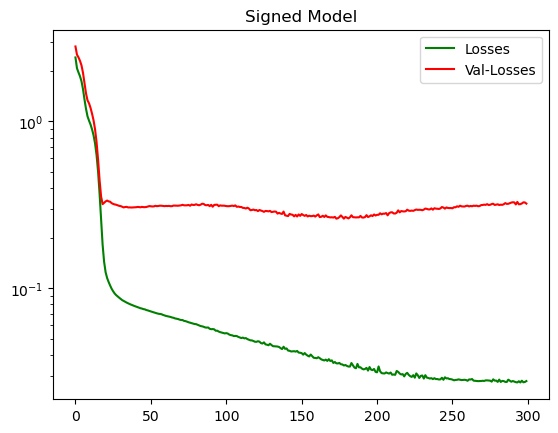

In [13]:
# plotting the losses in log plot
plt.semilogy(losses,color=('green'),label=('Losses'))
plt.semilogy(val_losses,color=('red'),label=('Val-Losses'))
plt.legend()
plt.title('Signed Model')


In [14]:
#save model, later on we can directly use.
torch.save(model, 'signedmodel.pt')

#we can use model from here  without running epochs
#try printing
#model = torch.load('signedmodel.ptt')

In [15]:
y_pred = model(torch.Tensor(backupfeatures))
print(f"MSE over the model prediction: {mean_absolute_error(backuptarget.tolist(), y_pred.tolist())}")


MSE over the model prediction: 0.13741449765660274


In [16]:
prediction = model(torch.Tensor(backupfeatures))[:,0]
prediction = prediction.detach().numpy().flatten()

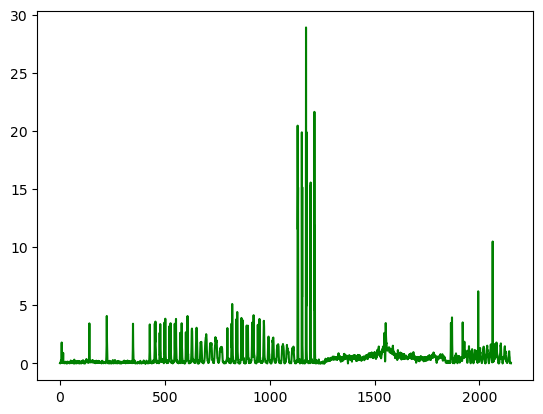

In [17]:
plt.plot(backuptarget.flatten(),color=('green'))

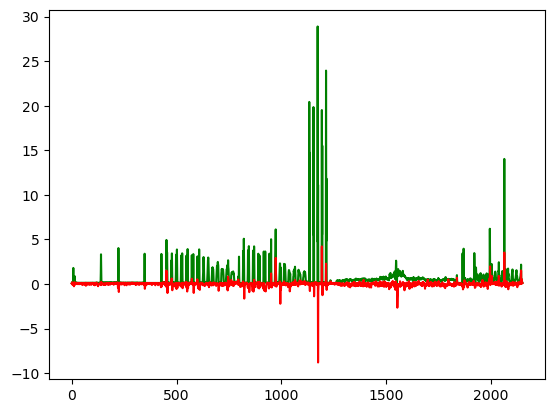

In [18]:

plt.plot(prediction, color='green')
plt.plot(prediction-backuptarget.flatten(),color='red')